In [402]:
import os

os.chdir("c:/Work/WORK_PACKAGE/Demand_forecasting/github/DeepAR-pytorch/My_model/2_freq_nbinom_LSTM")

In [403]:
#from ctypes import FormatError
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os,sys

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))

import torch
torch.use_deterministic_algorithms(True)

from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE
from torchmetrics import R2Score, SymmetricMeanAbsolutePercentageError, MeanSquaredError

import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle
from pytorch_forecasting import Baseline
import random
from pytorch_forecasting import DeepAR,NegativeBinomialDistributionLoss,NormalDistributionLoss
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import combinations
from os import listdir


In [404]:
"""
Set Random seed
"""

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
## additional seeding to ensure reproduciblility.
pl.seed_everything(0)


Global seed set to 0


0

In [405]:
os.chdir("c:/Work/WORK_PACKAGE/Demand_forecasting/github/DeepAR-pytorch/My_model/2_freq_nbinom_LSTM/1_cluster_demand_prediction/data")

In [406]:
##########################################################################################
##########################################################################################
######### CREATE new augemented time series INDEX dataset of same past days #############

lk_bk = 12 #lookback
pst_lk_ah = 6 #past look ahead
pred_len = 2
cov_lag_len= 1
hist_len = lk_bk + pred_len + pst_lk_ah # history length
num_past_seas = 3
hrs_in_wk = 168
hrs_left = hrs_in_wk - hist_len # 168 hrs in a week


  #                              ENCODER                                        DECODER
  #
  # lk_bk + pred_len + pst_lk_ah      12 + 1 + 6     12 + 1 + 6        12 + 1 + 6            lk_bk |   prediction = pred_len
  #        _____________                  _                _                 _                _    |       _
  #       |             |________________| |______________| |_______________| |______________|     |        |
  #                       168 - hist_len    168 - hist_len   168 - hist_len    168 - hist_len

###### Only used to find length  #########
with open("final_response_ts_small_dataset.pkl",'rb') as f:
    final_response_ts = pickle.load(f)
df3 = pd.DataFrame(final_response_ts) 
df3 = pd.DataFrame(df3.iloc[cov_lag_len:]).reset_index(drop=True)
###### Only used to find length  #########

tot_len = df3.shape[0]
unusable = hist_len*num_past_seas + hrs_left*num_past_seas + lk_bk + pred_len


df_idx = pd.DataFrame({'hist_idx': np.array([]).astype(int) , 'group':[] })

start_idx = 0#(40+4*24 - 1)
end_idx = (tot_len - unusable)
increment = 1 #168 , increment by 168 so that all time series are correlated e.g. each subseries is a series of mondays.


group = 0
for i in range(start_idx,end_idx,increment):  
    hist_data_idx = np.array([]).astype(int)
    k=i

    for j in range(num_past_seas):
      hist_data_idx = np.append(hist_data_idx, np.arange(k+j*hrs_in_wk , k+hist_len+j*hrs_in_wk) )
      #k=k+hist_len
    
    hist_data_idx = np.append(hist_data_idx, np.arange(k+(j+1)*hrs_in_wk , (k+lk_bk+pred_len)+(j+1)*hrs_in_wk) )
    one_train_inst_len = hist_data_idx.shape[0]
    #print(one_train_inst_len)
    grp_list = np.repeat(group, one_train_inst_len)
    grp_list = np.expand_dims(grp_list,axis=-1)
    hist_data_idx = np.expand_dims(hist_data_idx,axis=-1)
    arr = np.concatenate((hist_data_idx,grp_list),axis=1)

    df_idx = pd.concat([df_idx, pd.DataFrame(arr, columns=["hist_idx","group"])], axis=0)
    df_idx['group'] = df_idx['group'].astype(int)
    group+=1

df_idx

######### CREATE new augemented time series INDEX dataset of same past days #############
############################# #############################################################
##########################################################################################

print(df_idx.shape[0])


36260


In [407]:
end_idx

490

In [408]:
os.chdir("c:/Work/WORK_PACKAGE/Demand_forecasting/github/DeepAR-pytorch/My_model/2_freq_nbinom_LSTM/1_cluster_demand_prediction/data/demand_data")

In [409]:
df_inflow = pd.read_csv('tampines_region_inflow_small_dataset.csv')
df7 = pd.DataFrame({'inflow':df_inflow['175'].values})
# lag covariate time series by cov_lag_len hour  to turn it into a 'time_varying_unknown_real' variable, 
df7 = pd.DataFrame(df7.iloc[:-cov_lag_len]).reset_index(drop=True)

os.chdir("c:/Work/WORK_PACKAGE/Demand_forecasting/github/DeepAR-pytorch/My_model/2_freq_nbinom_LSTM/1_cluster_demand_prediction/data")

"""
Import pre-processed Data

response and target are the same thing
"""
with open("final_response_ts_small_dataset.pkl",'rb') as f:
    final_response_ts = pickle.load(f)

with open("final_num_covariate_ts_small_dataset.pkl",'rb') as f:
    final_num_covariate_ts = pickle.load(f)

with open("final_cat_covariate_ts_small_dataset.pkl",'rb') as f:
    final_cat_covariate_ts = pickle.load(f)

###### concatenate response and covariate time series into a single dataframe  #########
df3 = pd.DataFrame(final_response_ts) # response and target are the same thing
# Remove the excess cov_lag_len hour for lagging covariate time series by cov_lag_len hour
df3 = pd.DataFrame(df3.iloc[cov_lag_len:]).reset_index(drop=True)

df4 = pd.DataFrame(final_num_covariate_ts)
# lag covariate time series by cov_lag_len hours to turn it into a 'time_varying_unknown_real' variable
df4 = pd.DataFrame(df4.iloc[:-cov_lag_len]).reset_index(drop=True)

df5 = pd.DataFrame(final_cat_covariate_ts)
# lag covariate time series by cov_lag_len hours to turn it into a 'time_varying_unknown_real' variable
df5 = pd.DataFrame(df5.iloc[:-cov_lag_len]).reset_index(drop=True)

df6 = pd.concat([df4,df5], axis=1) # dataframe of all covariates

df1 = pd.DataFrame({"time_idx":np.arange(0,df3.shape[0])})
df2 = pd.DataFrame({"group":np.tile(0,df3.shape[0])}) # identifies the series in case of univariate and multivariate series
df = pd.concat([df1,df2,df3,df7], axis=1)
###### concatenate response and covariate time series into a single dataframe  #########


#################### add date information ts ####################
df["date"] = pd.Timestamp(year=2021, month=9, day=25, hour=cov_lag_len) + pd.to_timedelta(df.time_idx, "H")
df['_hour_of_day'] = df["date"].dt.hour.astype(str)
df['_day_of_week'] = df["date"].dt.dayofweek.astype(str)
df['_day_of_month'] = df["date"].dt.day.astype(str)
df['_day_of_year'] = df["date"].dt.dayofyear.astype(str)
df['_week_of_year'] = df["date"].dt.weekofyear.astype(str)
df['_month_of_year'] = df["date"].dt.month.astype(str)
df['_year'] = df["date"].dt.year.astype(str)
#################### add date information ts ####################

Target = list(final_response_ts.keys())[0] # response and target are the same thing
inflow = 'inflow'


cat_col1 = list(final_cat_covariate_ts.keys())[0] # for column name agnostic
cat_col2 = list(final_cat_covariate_ts.keys())[1] # for column name agnostic
cat_col3 = list(final_cat_covariate_ts.keys())[2] # for column name agnostic
cat_col4 = list(final_cat_covariate_ts.keys())[3] # for column name agnostic

#num_cols_list = list(final_num_covariate_ts.keys())[:3] # for column name agnostic
#num_cols_list.append(Target) # for column name agnostic

df['wind_clstr_175'] = df6['wind_clstr_175'].values # add the covariate column
df['temp_clstr_175'] = df6['temp_clstr_175'].values  # add the covariate column
df['hum_clstr_175'] = df6['hum_clstr_175'].values  # add the covariate column
df['wea_clstr_175'] = df6['wea_clstr_175'].values  # add the covariate column
df['wea_desc_clstr_175'] = df6['wea_desc_clstr_175'].values  # add the covariate column
df['clstr_171'] = df6['clstr_171'].values  # add the covariate column
df['clstr_168'] = df6['clstr_168'].values  # add the covariate column
num_cols_list = ['hum_clstr_175','clstr_171']#,'hum_clstr_175','clstr_171','clstr_168']
num_cols_list.append('inflow')
#cat_col1 = 'wea_clstr_175'


In [410]:
init_idx_list = df_idx['hist_idx'].iloc[0:one_train_inst_len].values.tolist()

df = df.drop( columns=['group'])
new_df = pd.DataFrame(index=range(df_idx.shape[0]),columns=df.columns)
i_list = range(one_train_inst_len)
print(i_list)

len = int( df_idx.shape[0]/one_train_inst_len)

for i in range(len):

  new_df.iloc[i_list] = df.loc[init_idx_list]
  i_list = np.array(i_list)
  i_list = i_list + one_train_inst_len
  i_list = i_list.tolist()
  #print(i_list)

  init_idx_list = np.array(init_idx_list)
  init_idx_list = init_idx_list + increment
  init_idx_list = init_idx_list.tolist()
  #print(init_idx_list)

new_df['group'] = df_idx['group'].values
new_df['time_idx'] = np.tile(np.arange(one_train_inst_len), len ).tolist()
new_df.to_pickle('new_df.pkl')



range(0, 74)


In [411]:
new_df_pkl = pd.read_pickle("new_df.pkl")  

# plt.figure(figsize=(15,5))
# plt.plot(new_df_pkl['clstr_175'][38:51])
# plt.plot(df['clstr_175'][336:349])
# plt.show()

In [412]:

cov = list(df6.columns)
#print(cov)

cov_pairs_list = []
for p in combinations(cov,2):
  cov_pairs_list.append(p)

#cov_pairs_list

In [413]:
###### Create hyperparameters grid ###### 
# After tuning replace the list with the single best hparams value inside list

encoder_len = one_train_inst_len - pred_len

hparams_grid = {"LSTM_neuron_size":[512],
	            "num_layers":[2,3],
                "batch_size":[8,32],
                "learning_rate":[0.0001],
                "max_encoder_length":[encoder_len],
                "max_prediction_length":[pred_len],
                "dropout":[0.1],
	            "cov_pair":cov_pairs_list,
                "Num_epochs":[1]}#14,16,18,20,22,24,26]}#15,17,20,22,24,26,28,30,32,34,36,38,40]}
#"activation_functions":[],
###### Create hyperparameters grid ###### 
# 30,32,34,36,38,40,42,44,46,48,50,52,54

p = 10 # patience no. of epochs

Loss=NegativeBinomialDistributionLoss()
#Loss=NormalDistributionLoss()

param_comb_cnt=0
for neu,lay,bat,lr,enc_len,pred_len,drop,cov_pair,num_ep in product(*[x for x in hparams_grid.values()]):
    df_cov_col1 = cov_pair[0]
    df_cov_col2 = cov_pair[1]
    #print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2)
    param_comb_cnt+=1
param_comb_cnt

print(param_comb_cnt)

tot_hist_lengths = int(new_df_pkl.shape[0] / one_train_inst_len )

# tr_stop_idx = int(0.7* tot_hist_lengths* one_train_inst_len)
# val_stop_idx = tr_stop_idx + int(0.2* tot_hist_lengths* one_train_inst_len)
# tes_stop_idx = new_df_pkl.shape[0]
# print(tr_stop_idx)
# print(val_stop_idx)
# print(tes_stop_idx)

tr_stop_idx = int(end_idx*0.7)*one_train_inst_len
val_stop_idx = tr_stop_idx + int(end_idx*0.2)*one_train_inst_len
tes_stop_idx = new_df_pkl.shape[0]
# tr_stop_idx = 720
# val_stop_idx = 840
# tes_stop_idx = 960
print(tr_stop_idx)
print(val_stop_idx)
print(tes_stop_idx)



84
25382
32634
36260


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

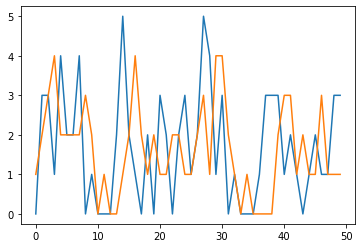

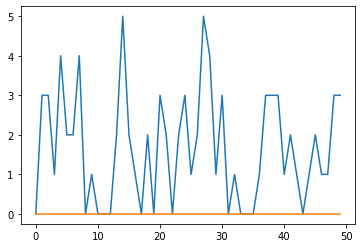

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


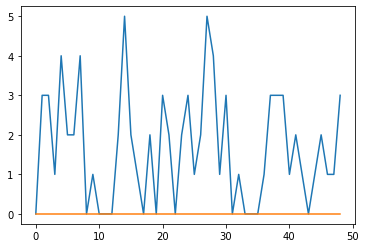

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 hum_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

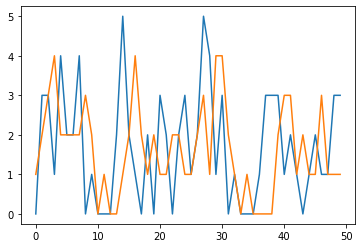

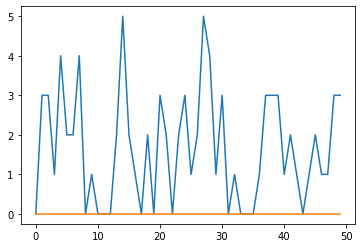

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


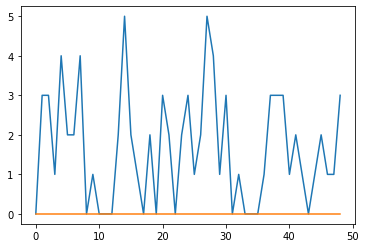

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 wind_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

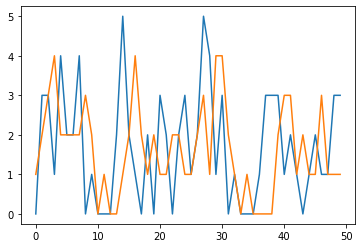

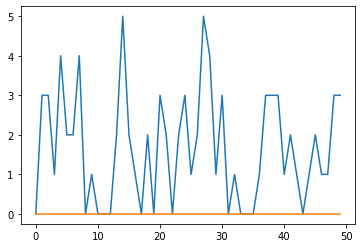

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


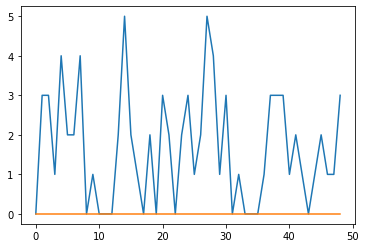

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

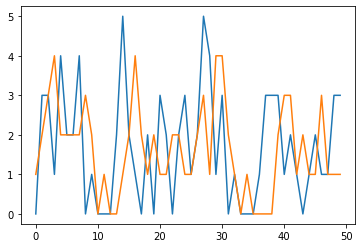

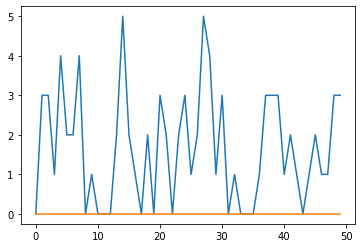

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


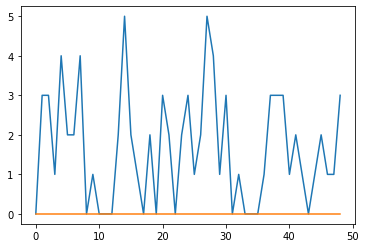

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

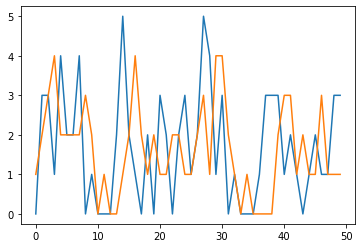

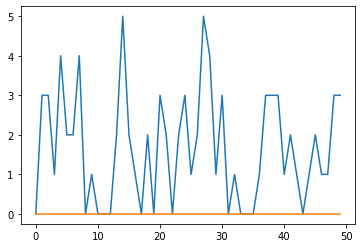

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


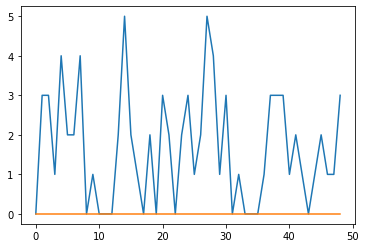

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

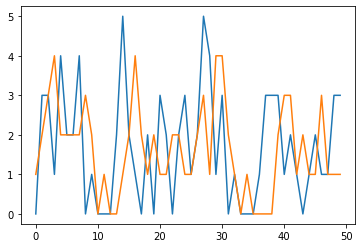

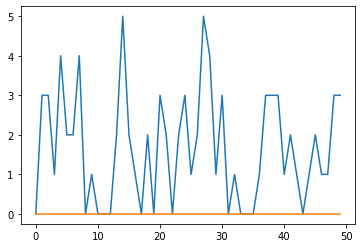

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


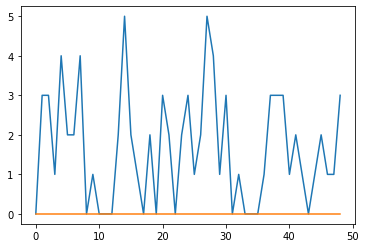

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

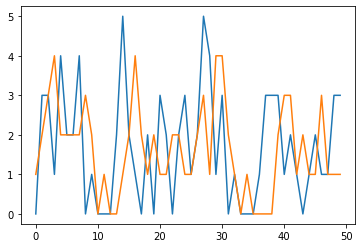

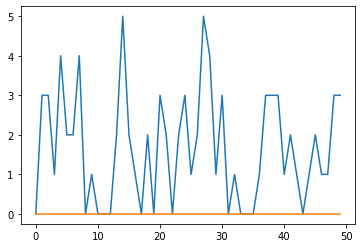

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


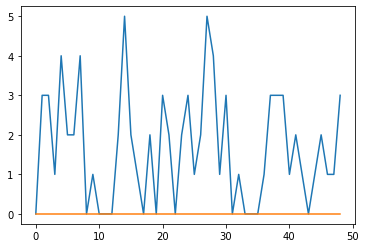

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow hum_clstr_175 wind_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

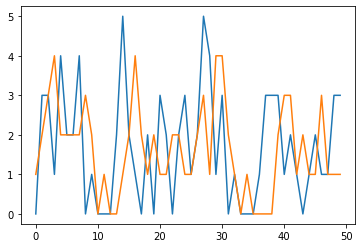

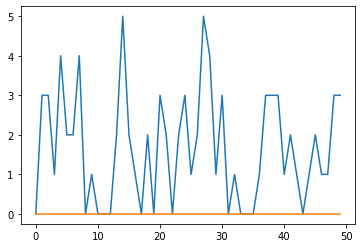

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


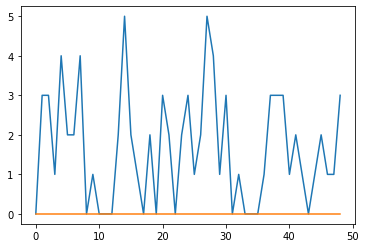

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow hum_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

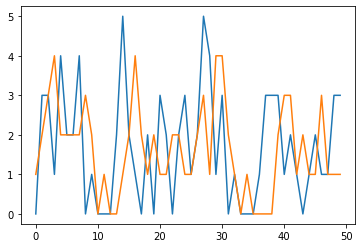

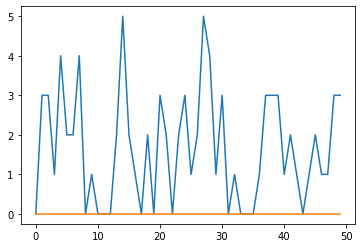

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


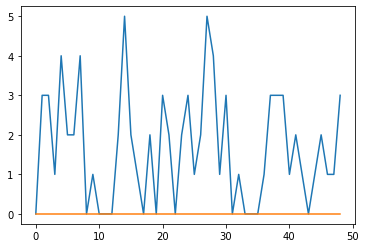

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow hum_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

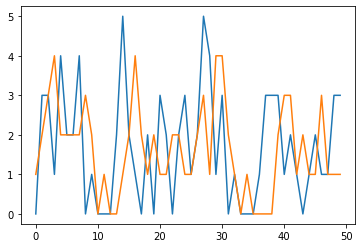

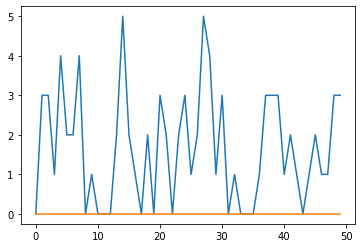

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


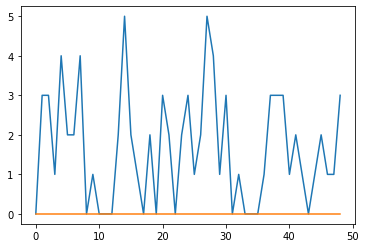

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow hum_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

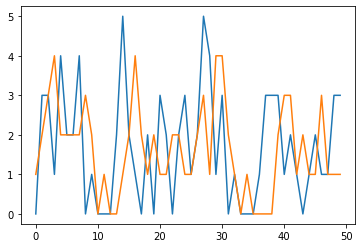

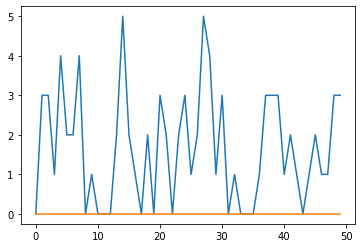

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


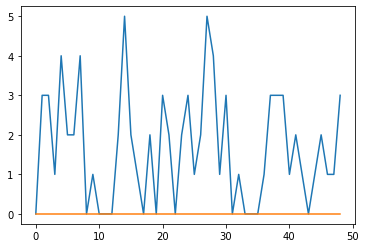

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow hum_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

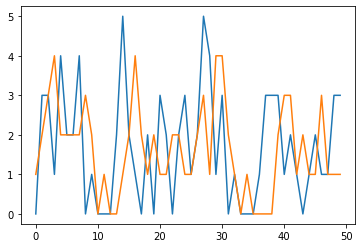

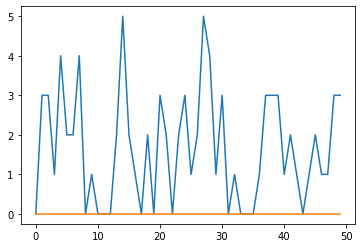

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


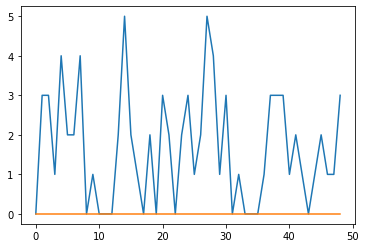

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wind_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

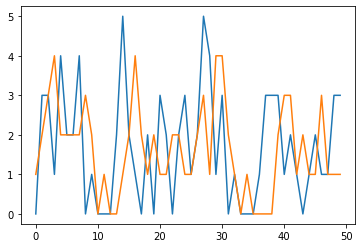

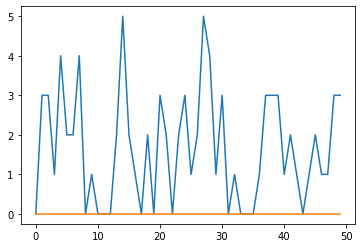

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


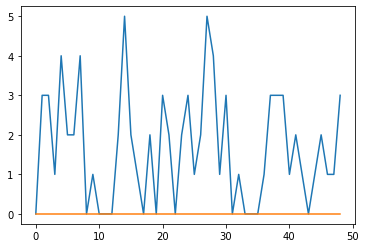

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wind_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

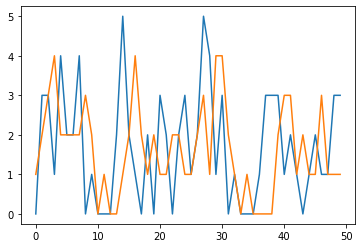

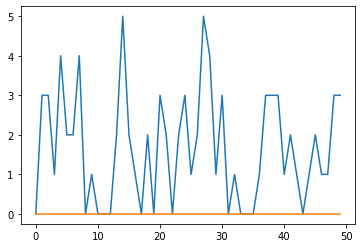

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


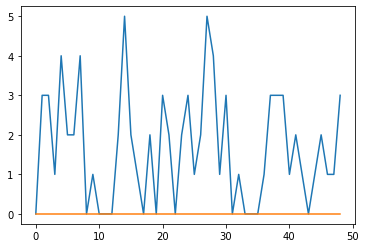

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wind_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

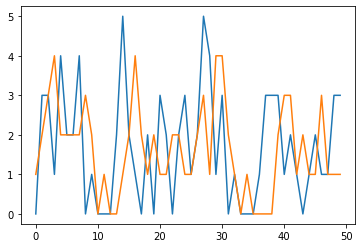

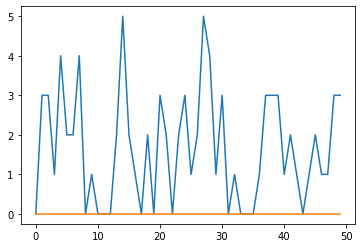

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


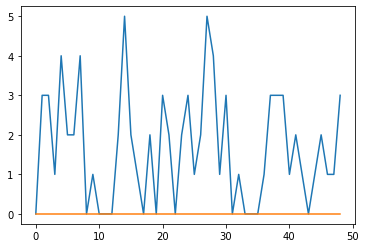

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wind_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.125 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

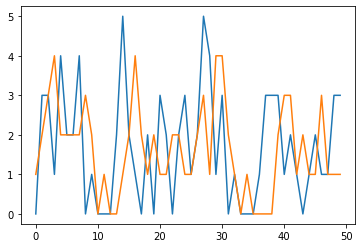

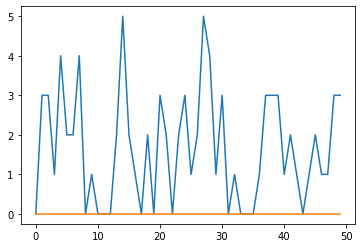

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


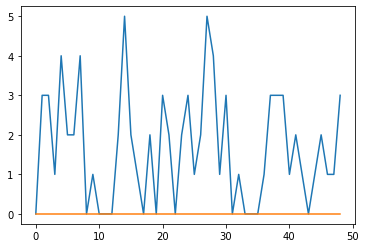

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wea_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

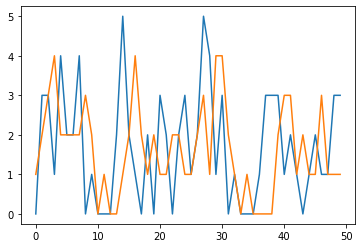

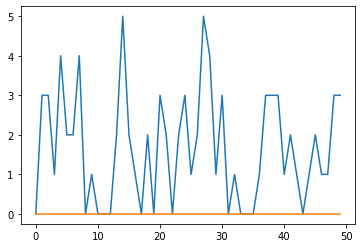

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


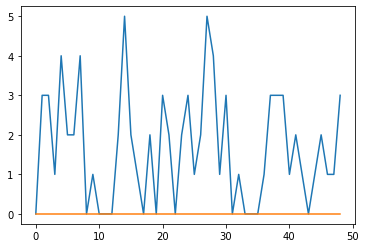

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wea_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

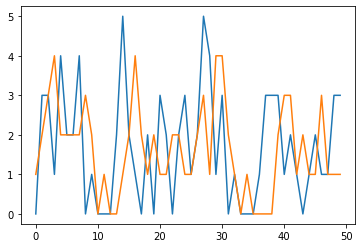

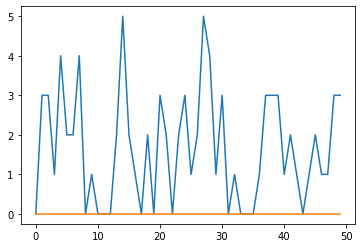

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


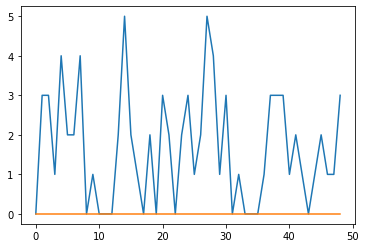

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wea_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

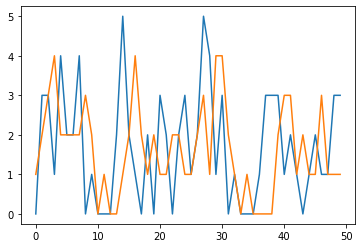

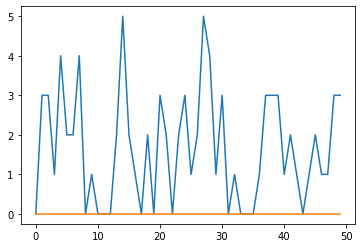

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


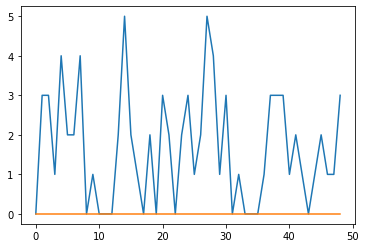

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wea_desc_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

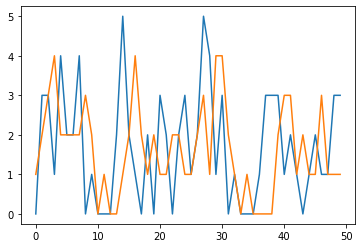

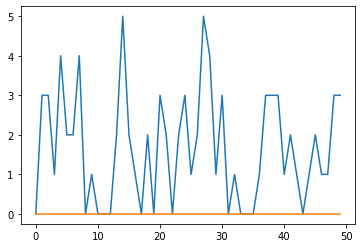

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


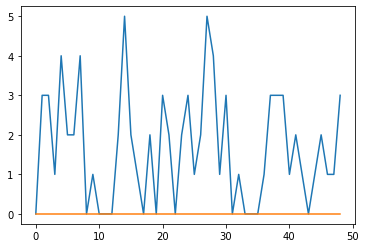

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow wea_desc_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

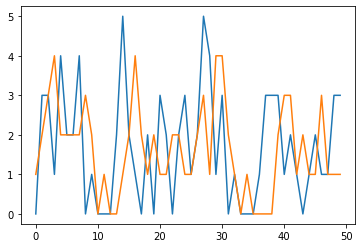

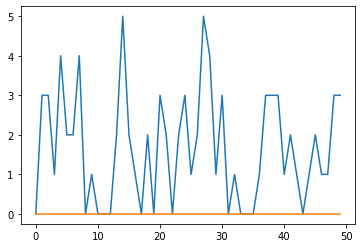

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


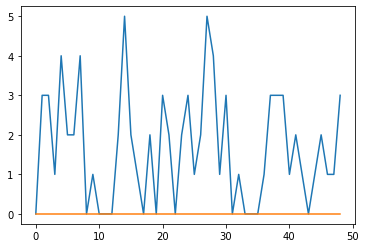

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 8 0.0001 72 2 0.1 1 inflow clstr_171 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

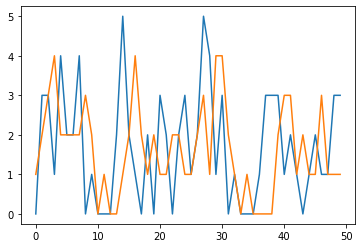

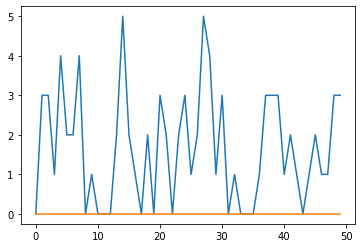

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


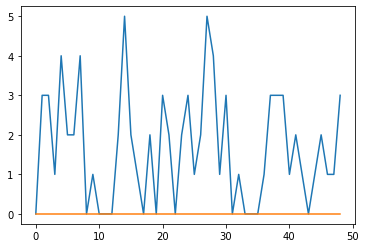

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow temp_clstr_175 hum_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

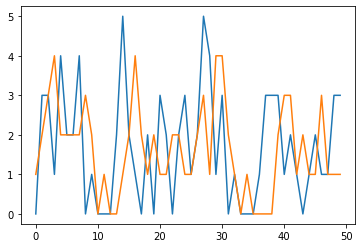

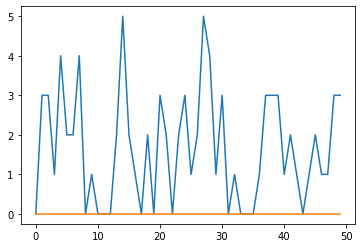

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


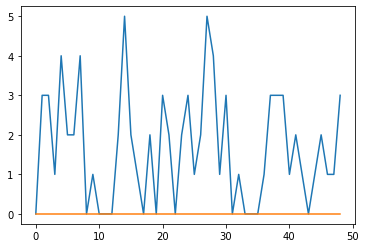

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow temp_clstr_175 wind_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

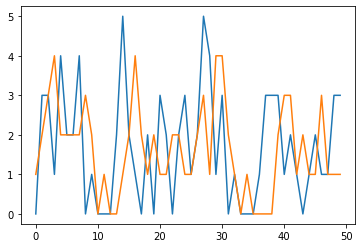

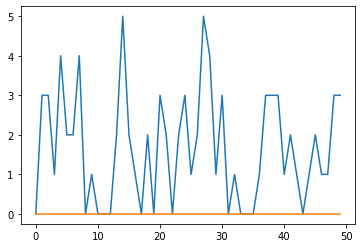

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


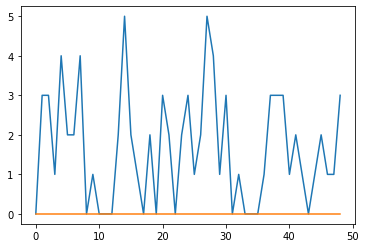

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow temp_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

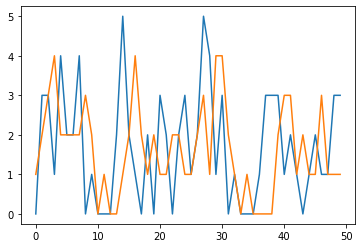

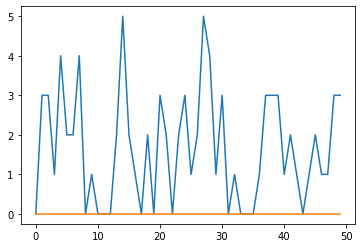

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


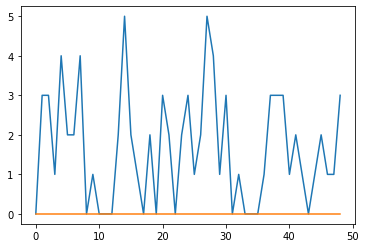

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow temp_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

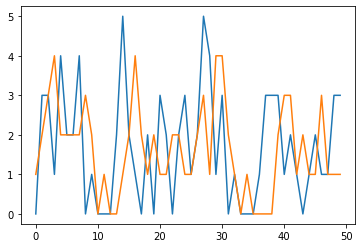

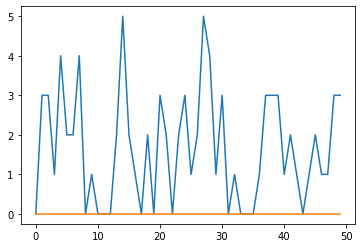

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


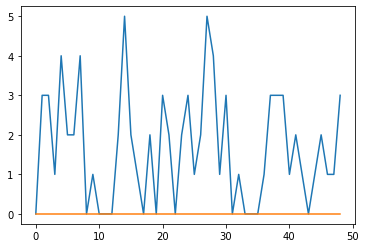

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow temp_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

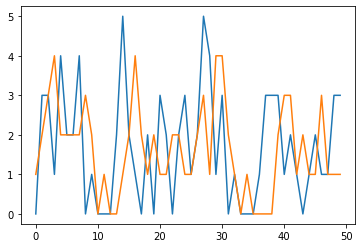

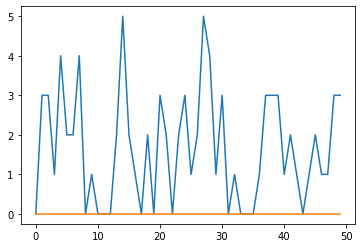

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


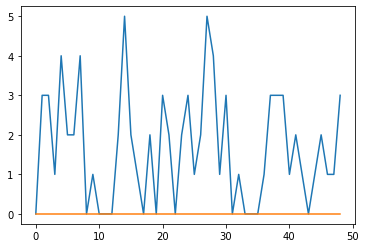

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow temp_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

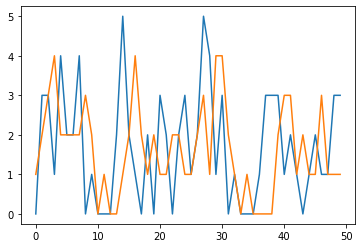

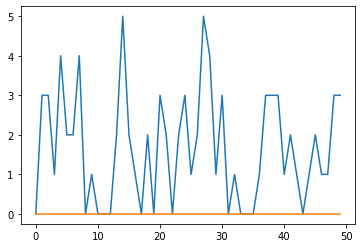

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


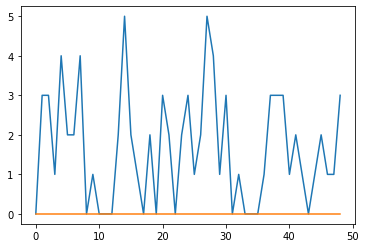

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow hum_clstr_175 wind_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

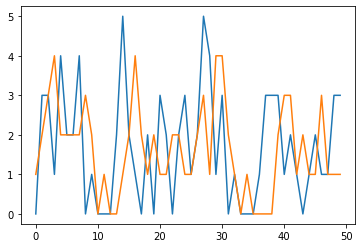

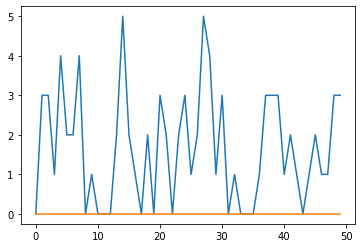

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


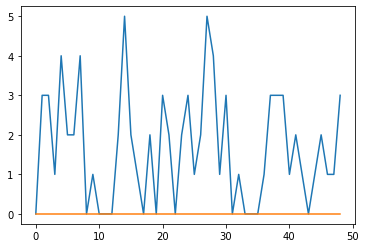

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow hum_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

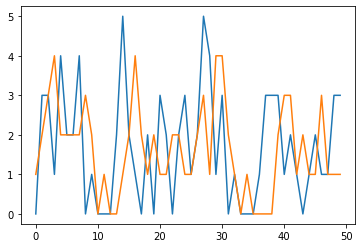

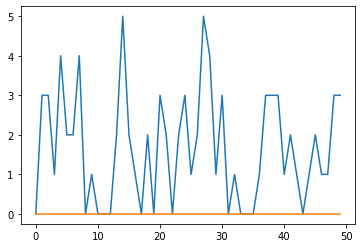

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


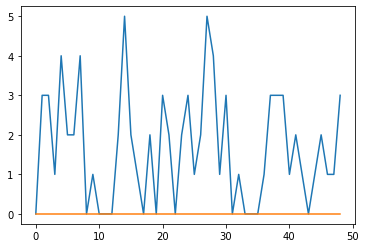

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow hum_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

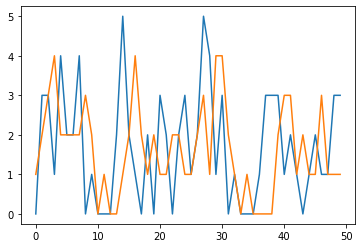

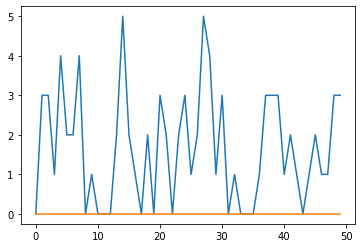

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


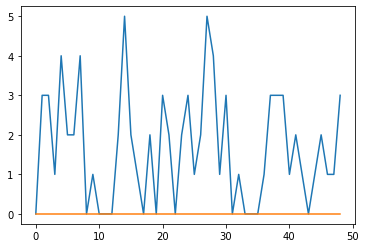

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow hum_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

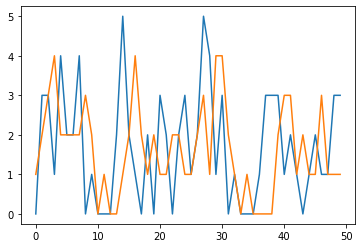

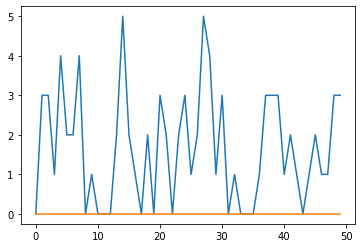

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


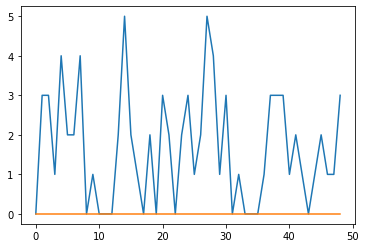

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow hum_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

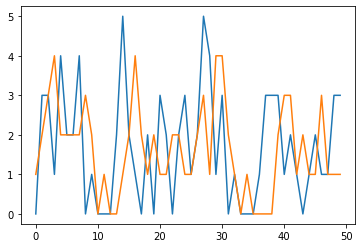

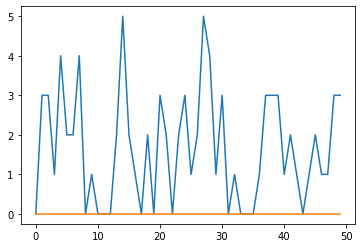

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


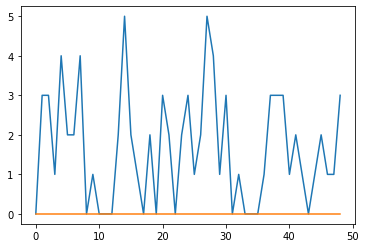

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wind_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

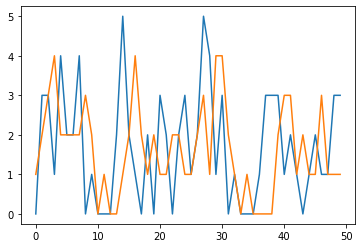

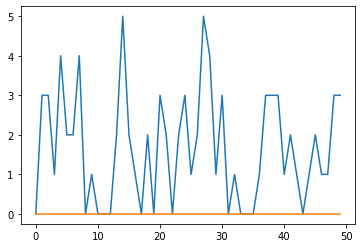

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


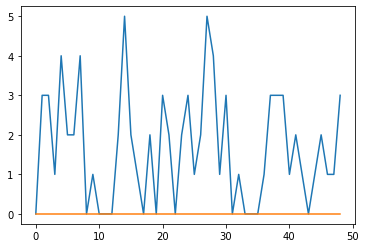

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wind_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

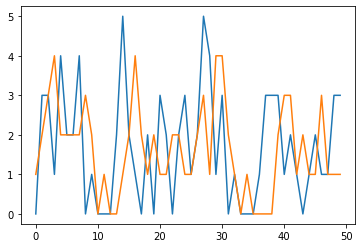

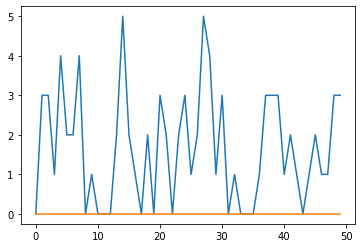

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


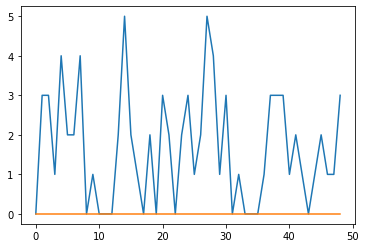

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wind_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

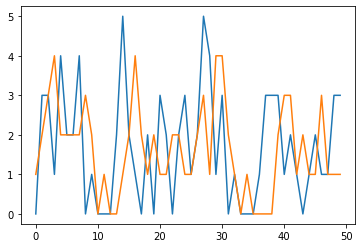

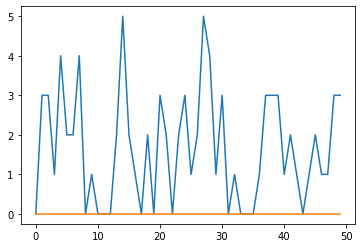

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


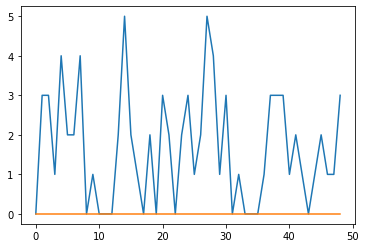

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wind_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.125 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

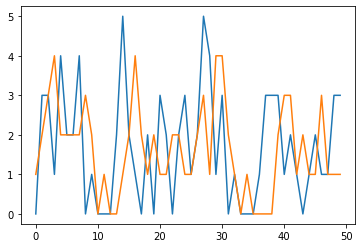

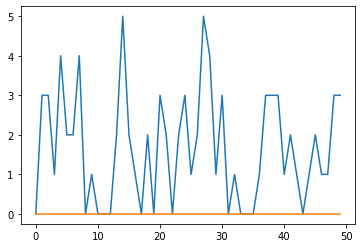

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


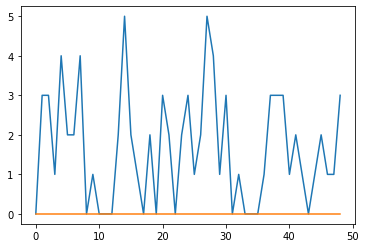

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wea_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

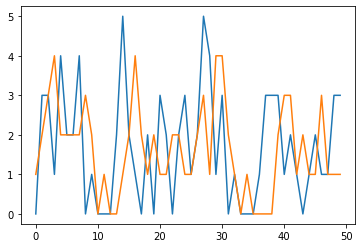

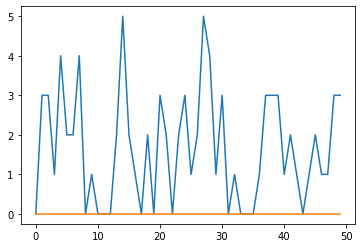

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


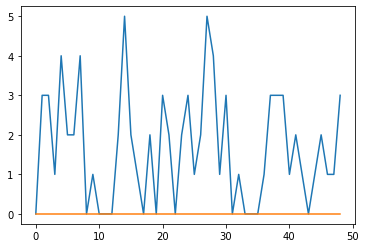

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wea_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.067 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

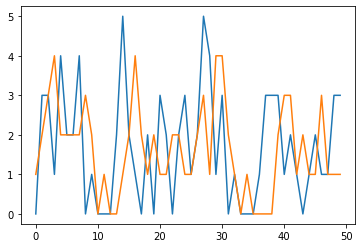

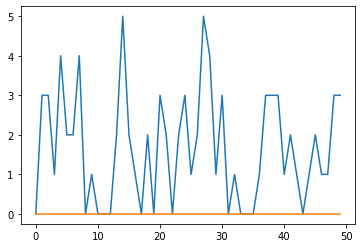

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


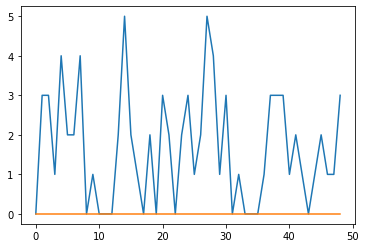

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wea_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

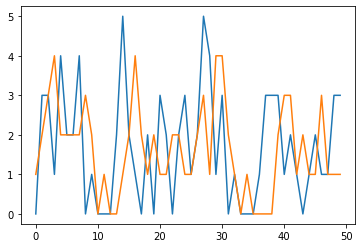

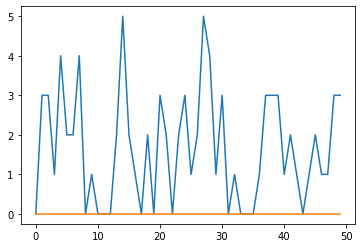

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


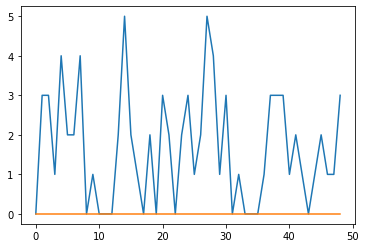

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wea_desc_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.101 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

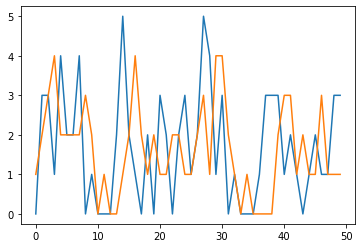

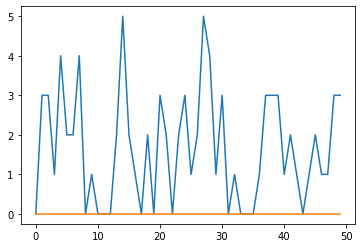

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


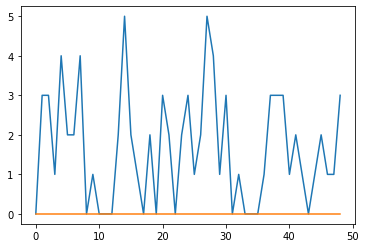

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow wea_desc_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 3.3 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.043 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

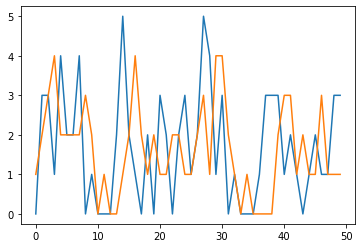

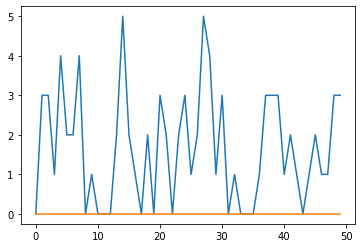

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


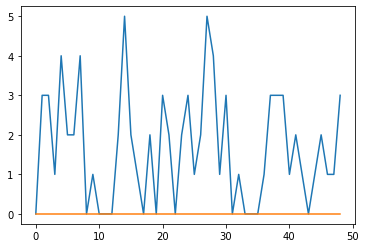

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 2 32 0.0001 72 2 0.1 1 inflow clstr_171 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 5.4 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.448 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

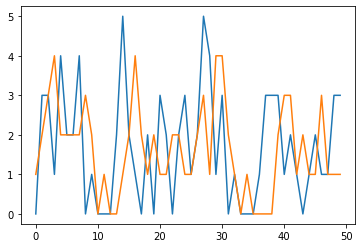

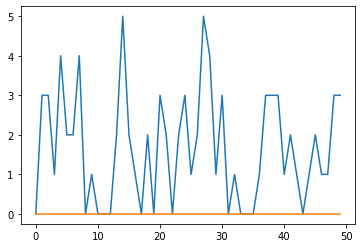

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


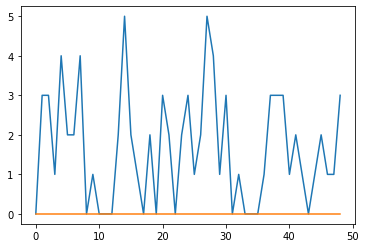

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 3 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 hum_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 5.4 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.448 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

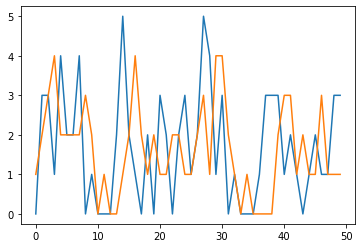

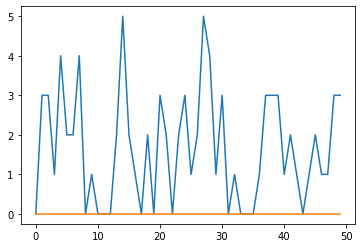

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


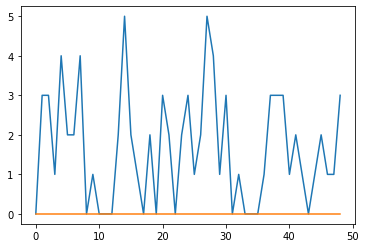

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 3 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 wind_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 5.4 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.472 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

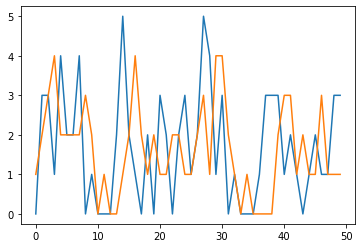

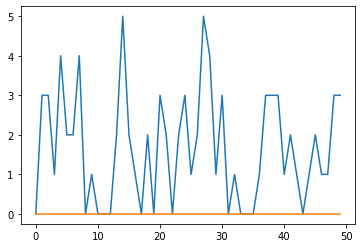

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


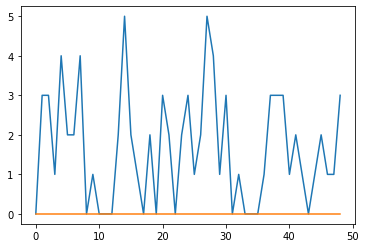

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 3 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 wea_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.4 K 
3 | rnn                    | LSTM                             | 5.4 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.505 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

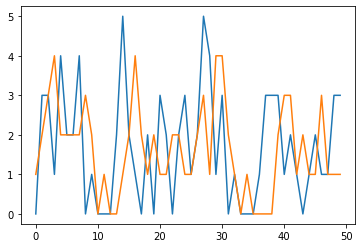

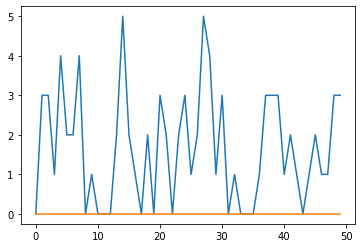

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


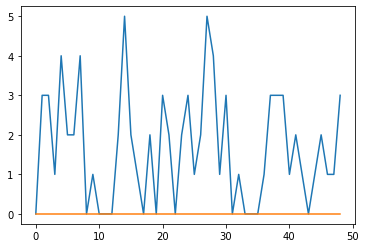

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 3 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 wea_desc_clstr_175  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 5.4 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.448 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

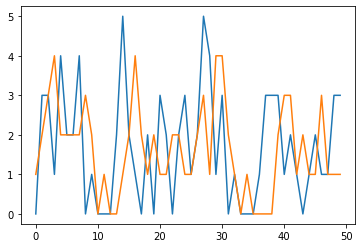

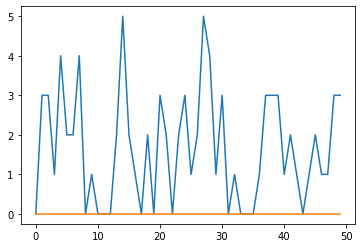

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


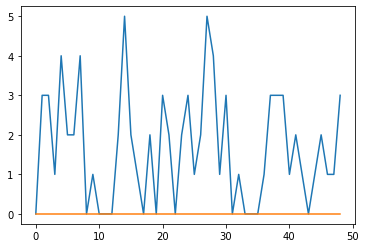

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 3 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 clstr_171  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.3 K 
3 | rnn                    | LSTM                             | 5.4 M 
4 | distribution_projector | Linear                           | 1.0 K 
----------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.448 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

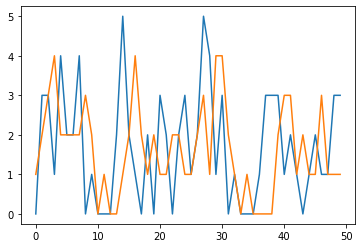

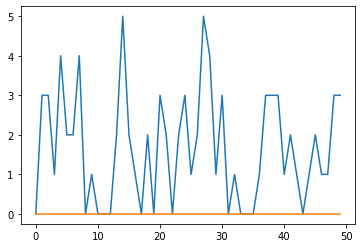

Hist. Average RMSE for 24.5 days:  1.5986818051338196
Model Average RMSE for 24.5 days:  1.9035801688828886


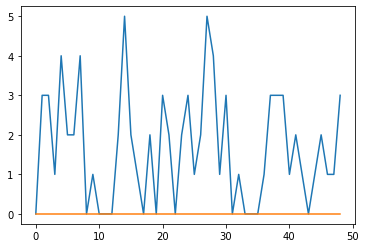

Hist. Average RMSE for 49.0 days:  1.3265306122448979
Model Average RMSE for 49.0 days:  1.653061224489796

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

84 512 3 8 0.0001 72 2 0.1 1 inflow temp_clstr_175 clstr_168  



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [414]:
#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=p, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

for neu,lay,bat,lr,enc_len,pred_len,drop,cov_pair,num_ep in product(*[x for x in hparams_grid.values()]):
     
  df_cov_col1 = cov_pair[0]
  df_cov_col2 = cov_pair[1]

  if (df_cov_col1[:3] == 'wea' and df_cov_col2[:3] != 'wea'): 
        num_cols_list = [df_cov_col2]
        cat_col1 = df_cov_col1
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  elif (df_cov_col2[:3] == 'wea' and df_cov_col1[:3] != 'wea'): 
        num_cols_list = [df_cov_col1]
        cat_col1 = df_cov_col2
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  elif (df_cov_col1[:3] == 'wea' and df_cov_col2[:3] == 'wea'): 
        num_cols_list = []
        cat_col1 = df_cov_col1
        cat_col2 = df_cov_col2
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),cat_col2: NaNLabelEncoder(add_nan=True).fit(df[cat_col2]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,cat_col2,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  else:
        num_cols_list = [df_cov_col1,df_cov_col2] # numerical covariate
        cat_dict = {"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = ["_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]

  train_dataset = TimeSeriesDataSet(
      new_df_pkl.iloc[0:tr_stop_idx],
      time_idx="time_idx",
      target=Target,
      categorical_encoders=cat_dict,
      group_ids=["group"],
      min_encoder_length=enc_len,
      max_encoder_length=enc_len,
      min_prediction_length=pred_len,
      max_prediction_length=pred_len,
      time_varying_unknown_reals=[Target],
      time_varying_known_reals=num_cols_list,
      time_varying_known_categoricals=cat_list,
      add_relative_time_idx=False,
      randomize_length=False,
      scalers={},
      target_normalizer=TorchNormalizer(method="identity",center=False,transformation=None )

  )

  val_dataset = TimeSeriesDataSet.from_dataset(train_dataset,new_df_pkl.iloc[tr_stop_idx:val_stop_idx], stop_randomization=True, predict=False)
  test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,new_df_pkl.iloc[val_stop_idx:tes_stop_idx], stop_randomization=True)

  train_dataloader = train_dataset.to_dataloader(train=True, batch_size=bat)
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=bat)
  test_dataloader = test_dataset.to_dataloader(train=False, batch_size=bat)

  """
  Data loading sanity check

  """

  # ####### View the entire data using this code ##################
  # print(train_dataset.data['categoricals'])
  # ####### View the data entire using this code ##################

  # ####### View the data for each batch using this code ##################
  # for x,y in iter(train_dataloader):
  #     print(x)
  #     break
  # ####### View the data for each batch using this code ##################

  trainer = pl.Trainer(
      max_epochs=num_ep,
      gpus=0, #-1,0
      #auto_lr_find=True,
      gradient_clip_val=0.1,
      limit_train_batches=1.0,
      limit_val_batches=1.0,
      #fast_dev_run=fdv_steps,
      logger=True,
      #log_every_n_steps=10,
      # profiler=True,
      callbacks=[lr_logger],
      enable_checkpointing=True)

  #print(f"training routing:\n \n {trainer}")
  deepar = DeepAR.from_dataset(
      train_dataset,
      learning_rate=lr,
      hidden_size=neu,
      rnn_layers=lay,
      dropout=drop,
      loss=Loss,
      log_interval=10,
      log_val_interval=3,
      log_gradient_flow=False,
      # reduce_on_plateau_patience=3,
  )



  #print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")
  # print(f"Model :\n \n {deepar}")
  torch.set_num_threads(10)
  trainer.fit(
      deepar,
      train_dataloaders=train_dataloader,
      val_dataloaders=val_dataloader,
  )

  ########## Prediction #####################
  test_output = deepar.predict(data=test_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)
  #print('test_output shape',test_output.shape)
  
  collate_act = np.array([])
  #collate_act1 = []
  collate_pred = np.array([])
  collate_HA = np.array([])
  
  pred_start_idx_list = []
  season_len = 168 # length of season
  RMSE_list = np.array([])
  RMSE_list1 = np.array([])
  b = 2
  #RMSE_preak_pred_list = np.array([])
  days = test_output[1].shape[0]
  for j in range(0,days,pred_len):

    x = new_df_pkl.index[ (new_df_pkl['group'] ==  test_output[1]['group'][j])].tolist()
    y = new_df_pkl.index[ (new_df_pkl['time_idx'] == test_output[1]['time_idx'][j]) ].tolist()
    pred_start_idx = list(set(x).intersection(y))[0]
    pred_start_idx_list.append(pred_start_idx)
    #pred_start_idx = int(test_output[1]['time_idx'][j])

    #print('pred_start_idx ',pred_start_idx)

    actual = new_df_pkl[Target].iloc[pred_start_idx:pred_start_idx+pred_len].values
    collate_act = np.append(collate_act, actual)
    #plt.plot(actual,'*')

    pred = np.array(np.rint(test_output[0][j])).astype(int)
    collate_pred = np.append(collate_pred, pred)
    #plt.plot(pred,'.')
    #plt.show()
    RMSE = np.sqrt(mean_squared_error(actual,pred ))
    #print('RMSE : ',RMSE)
    RMSE_list = np.append(RMSE_list,RMSE)
    
    # Historical AVG prediction
    strt_idx = df_idx['hist_idx'].iloc[pred_start_idx]
    actuals1 = df[Target].iloc[strt_idx:strt_idx+pred_len].values
    #collate_act1.append(actuals1)
    predictions = np.array([])

    for h in range(pred_len):
        sum1 = 0
        for n in range(num_past_seas):
            #print(strt_idx+h - season_len*n)
            sum1 = sum1 + df[Target][strt_idx-b+h - season_len*n]
        
        predictions = np.append(predictions,sum1/num_past_seas)

    predictions = np.rint(predictions).astype(int)
    collate_HA = np.append(collate_HA,predictions)
    actuals1 = np.array(actuals1)

    mse = MeanSquaredError()

    RMSE1 = np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))
    RMSE_list1 = np.append(RMSE_list1,RMSE1)

    #print(f" Persistance model ( seasonal naive forecast ) , R2 Score : {r2score( torch.Tensor(predictions),torch.Tensor(actuals1)) }" )
    # plt.title("(average) seasonal naive forecast")
    # plt.plot(predictions,color='r')
    # plt.plot(actuals1,color='b')
    # plt.show()

  collate_act = collate_act.flatten()
  #collate_act1 = [x for x in collate_act1]
  collate_pred = collate_pred.flatten()
  collate_HA = collate_HA.flatten()

  plt.plot(collate_act)
  plt.plot(collate_HA)
  plt.show()
  plt.plot(collate_act)
  plt.plot(collate_pred)
  plt.show()

  print(f'Hist. Average RMSE for {days/pred_len} days: ',np.mean(RMSE_list1))
  print(f'Model Average RMSE for {days/pred_len} days: ',np.mean(RMSE_list))



 ##### take the first prediction and collate them ########

  collate_act1 = np.array([])
  #collate_act1 = []
  collate_pred1 = np.array([])
  collate_HA1 = np.array([])
  
  pred_start_idx_list1 = []
  season_len1 = 168 # length of season
  RMSE_list1a = np.array([])
  RMSE_list11a = np.array([])
  b1 = 2
  #RMSE_preak_pred_list = np.array([])
  days1 = test_output[1].shape[0]
  pred_len1 =1
  for j1 in range(0,days1,pred_len1):

    x1 = new_df_pkl.index[ (new_df_pkl['group'] ==  test_output[1]['group'][j1])].tolist()
    y1 = new_df_pkl.index[ (new_df_pkl['time_idx'] == test_output[1]['time_idx'][j1]) ].tolist()
    pred_start_idx1 = list(set(x1).intersection(y1))[0]
    pred_start_idx_list1.append(pred_start_idx1)
    #print('pred_start_idx1', pred_start_idx1)
    #pred_start_idx = int(test_output[1]['time_idx'][j])

    #print('pred_start_idx ',pred_start_idx)

    actual1 = new_df_pkl[Target].iloc[pred_start_idx1:pred_start_idx1+pred_len1].values
    collate_act1 = np.append(collate_act1, actual1)
    #plt.plot(actual,'*')

    pred1 = np.rint(np.array(np.rint(test_output[0][j1][0])).astype(int))
    collate_pred1 = np.append(collate_pred1, pred1)
    RMSE1 = np.sqrt((actual1[0] - pred1 )**2)

    #print('RMSE : ',RMSE)
    RMSE_list1a = np.append(RMSE_list1a,RMSE1)
    
    # Historical AVG prediction
    strt_idx1 = df_idx['hist_idx'].iloc[pred_start_idx1]
    actuals11 = df[Target].iloc[strt_idx1:strt_idx1+pred_len1].values
    #collate_act1.append(actuals1)
    predictions1 = np.array([])

    for h in range(pred_len1):
        sum11 = 0
        for n in range(num_past_seas):
            #print(strt_idx+h - season_len*n)
            sum11 = sum11 + df[Target][strt_idx1-b+h - season_len*n]
        
        predictions1 = np.append(predictions1,sum11/num_past_seas)

    predictions1 = np.rint(predictions1).astype(int)
    collate_HA1 = np.append(collate_HA1,predictions1)
    actuals11 = np.array(actuals11)

    mse = MeanSquaredError()

    RMSE11 = np.sqrt(mse(torch.Tensor(predictions1),torch.Tensor(actuals11)))
    RMSE_list11a = np.append(RMSE_list11a,RMSE11)

    #print(f" Persistance model ( seasonal naive forecast ) , R2 Score : {r2score( torch.Tensor(predictions),torch.Tensor(actuals1)) }" )
    # plt.title("(average) seasonal naive forecast")
    # plt.plot(predictions,color='r')
    # plt.plot(actuals1,color='b')
    # plt.show()

  collate_act1 = collate_act1.flatten()
  #collate_act1 = [x for x in collate_act1]
  collate_pred1 = collate_pred1.flatten()
  collate_HA1 = collate_HA1.flatten()


  plt.plot(collate_act1)
  plt.plot(collate_pred1)
  plt.show()

  print(f'Hist. Average RMSE for {days/pred_len1} days: ',np.mean(RMSE_list11a))
  print(f'Model Average RMSE for {days/pred_len1} days: ',np.mean(RMSE_list1a))
 ##### take the first prediction and collate them ########




  #print(f'Average RMSE_peak_pred for {days} days: ',np.mean(RMSE_preak_pred_list))

  print('\n Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2\n')
  print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,inflow,df_cov_col1,df_cov_col2,' \n')
  ########## Prediction #####################




In [ ]:
pred1 = np.rint(np.array(np.rint(test_output[0][j1][0])).astype(int))
collate_pred1 = np.append(collate_pred1, pred1)

RMSE1 = np.sqrt((actual1[0] - pred1 )**2)

0.0

In [ ]:
# ########### prediction using Historical Average #############
# num_past_seas = 4
# ############## 2) Persistance model ( seasonal naive forecast ) #######################
# RMSE_list1 = np.array([])
# b = 2 # bias
# for pred_start_idx in pred_start_idx_list:
#         # Historical AVG prediction
#     predictions = np.array([])
#     strt_idx = df_idx['hist_idx'].iloc[pred_start_idx]
#     actuals1 = df[Target].iloc[strt_idx:strt_idx+pred_len].values

#     for h in range(pred_len):
#         sum1 = 0
#         for n in range(num_past_seas):
#             #print(strt_idx+h - season_len*n)
#             sum1 = sum1 + df[Target][strt_idx-b+h - season_len*n]
        
#         predictions = np.append(predictions,sum1/num_past_seas)

#     predictions = np.rint(predictions).astype(int)
#     actuals1 = np.array(actuals1)

#     mse = MeanSquaredError()

#     RMSE1 = np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))
#     RMSE_list1 = np.append(RMSE_list1,RMSE1)


#     #print(f" Persistance model ( seasonal naive forecast ) , R2 Score : {r2score( torch.Tensor(predictions),torch.Tensor(actuals1)) }" )
#     plt.title("(average) seasonal naive forecast")
#     plt.plot(predictions,color='r')
#     plt.plot(actuals1,color='b')
#     plt.show()
#     print('RMSE : ',float(RMSE1))

# print(f'Hist. Average RMSE for {days/pred_len} days: ',np.mean(RMSE_list1))


# ########### prediction using Historical Average #############